In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
sns.color_palette("husl", 10)
import missingno as msno

from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import DataConversionWarning
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
from warnings import filterwarnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

from fractions import Fraction
from string import ascii_letters

def frac_to_float(frac):
    try:
        if isinstance(frac, float):
            return frac
        if frac == "1 / 200s":
            frac = "1/200"
        return float(sum(Fraction(s.rstrip(ascii_letters)) for s in frac.split()))
    except:
        print(frac)

# Data Notes
## train.csv
* Columns with Null: description1, description2, lat, lon, country, city
* Columns uncorrelated with "stats_downloaded": latitude, longitude, 

## train_keywords.csv
*  Columns with Null: confidence_value

In [204]:
# Load/Preprocess data

train = pd.read_csv("data/train.csv")
train_colors = pd.read_csv("data/train_colors.csv")
train_keywords = pd.read_csv("data/train_keywords.csv")
test = pd.read_csv("data/test.csv")
test_colors = pd.read_csv("data/test_colors.csv")
test_keywords = pd.read_csv("data/test_keywords.csv")

cam_make_map = {
 "ASUS": "Asus", "Cannon": "Canon", 
 'Canon, SVR 90mm, 15 images': "Canon",
 'Canon, SVR90, 15 images': "Canon",
 'Canon, SVR90mm, 11 images': "Canon",
 'Canon, WOGT71, 19 images': "Canon",
 'Canon, WOGT71, 26 images': "Canon",
 'Canon, WOGT71, 32 images': "Canon",
 "canon": "Canon",
 'DJI Mavic 2 Pro': "DJI",
 'DJI Mavic Pro': "DJI",
 'DJI Spark': "DJI",
 'FUJIFILM': "Fujifilm",
 'FujiFilm': "Fujifilm",
 'Fujica': "Fujifilm",
 "google": "Google",
 'HASSELBLAD': "Hasselblad",
 "HUAWEI": "Huawei",
 'LEICA CAMERA AG': "LEICA",
 'Leica Camera AG': "LEICA",
 'LG Electronics': "LGE",
 'NIKON': "Nikon",
 'NIKON CORPORATION': "Nikon",
 'OLYMPUS CORPORATION': "Olympus",
 'OLYMPUS IMAGING CORP.': "Olympus",
 'PENTAX Corporation': "Pentax",
 'PENTAX RICOH IMAGING': "Pentax",
 "PENTAX": "Pentax",
 'RICOH IMAGING COMPANY, LTD.': "Ricoh",
 "SAMSUNG": "Samsung",
 "SONY": "Sony",
 "XIAOMI": "Xiaomi",
 'XIAOYI': "Xiaomi",
 'ZWO WOGT71': "ZWO",
 'ZWO w/ WOGT71 21 frames each SHO': "ZWO",
 'ZWO, WOGT71, 15 frames each of H, O, S': "ZWO",
 'motorola': "Motorola",
 "nikon": "Nikon",
 "olympus": "Olympus",
 "samsung": "Samsung",
 "sony": "Sony",
 }

train = train[(train["stats_downloads"] < 300000)]
train["image_category"] = train["image_category"].replace({"Featured": 1, "Not Featured": 0})
train["camera_make"] = train["camera_make"].replace(cam_make_map)
train["camera_make"] = train["camera_make"].apply(lambda x: str(x).lower())
make_counts = train["camera_make"].value_counts()

# Remove instances where camera_make <= 10
train = train[train["camera_make"].isin(make_counts[make_counts > 10].index)]
train["exposure_time"] = train["exposure_time"].apply(frac_to_float)
train["photo_submitted_at"] = pd.to_datetime(train["photo_submitted_at"])

# Fill Missing Values
train["aperture_value"] = train["aperture_value"].fillna(train["aperture_value"].mean())
train["iso"] = train["iso"].fillna(train["iso"].mean())
train["exposure_time"] = train["exposure_time"].fillna(train["exposure_time"].mean())

# Fill missing camera_make data based on camera_model data
make_replace_id = ["eca7e87d03", "bee68f9815", "5e15dcf061", "efd3bf77ec", "63cd2598c2", "759de7f18d", "8b215885c7", "c83069821b", "4bdba7914b", "913cc10182"]
make_replace_str = ["olympus", "nikon", "canon", "nikon", "nikon", "nikon", "canon", "sony", "olympus", "olympus"]
for replace_id, replace_str in zip(make_replace_id, make_replace_str):
    train.loc[train["image_id"] == replace_id, "camera_make"] = replace_str

# Drop unnecessary columns
train.drop(columns=["photo_url", "photo_image_url", "photo_submitted_at", "obs_min", "obs_sec", "width", "height", "iso", "aperture_value", "focal_length", "exposure_time", "latitude", "longitude", "country", "city"], inplace=True)

# Day and hour may be important, keep aspect ratio because image dimensions make sense to affect download rates (if image is shaped too tall or wide it could be negative)

train_num = train.select_dtypes(include=np.number)
train

,image_id,obs_day,obs_hour,image_category,aspect_ratio,description1,description2,camera_make,camera_model,total_days,stats_downloads
0,68105c019b,Thursday,15,1,1.500,Pristine water lily,rule of thirds photography of pink and white l...,canon,Canon EOS 60D,2361,167503
1,06d11c4edd,Wednesday,21,1,0.670,NaN,sand in desert,sony,ILCE-6500,1255,1839
2,f6599edba1,Tuesday,4,1,0.670,NaN,green trees near brown mountain during daytime,nikon,NIKON D850,1138,787
3,0f4bcc2d36,Monday,23,1,1.780,NaN,gray dock aerial photography,dji,FC220,1579,2049
4,74db502ed5,Saturday,11,1,1.500,NaN,people walking on green grass field near lake ...,fujifilm,X-T10,1050,2982
...,...,...,...,...,...,...,...,...,...,...,...
12192,18eaca644e,Monday,13,1,0.730,NaN,calm water during night time,canon,Canon EOS 5D Mark IV,1265,2353
12193,eb25cd769e,Monday,20,1,0.720,NaN,snowflakes on ground,canon,Canon EOS 5D Mark III,1503,3541
12194,73302461d0,Thursday,1,1,1.500,Inside of the small wave,NaN,canon,Canon EOS M,2501,14581
12195,f2587b2b08,Thursday,18,1,1.500,Tropical palm,low angle of banana tree,nikon,NIKON D5300,2508,9247


In [233]:
# test = test[(test["stats_downloads"] < 300000)]
test["image_category"] = test["image_category"].replace({"Featured": 1, "Not Featured": 0})
test["camera_make"] = test["camera_make"].replace(cam_make_map)
test["camera_make"] = test["camera_make"].apply(lambda x: str(x).lower())

test["exposure_time"] = test["exposure_time"].apply(frac_to_float)
test["photo_submitted_at"] = pd.to_datetime(test["photo_submitted_at"])

# Fill Missing Values
test["aperture_value"] = test["aperture_value"].fillna(test["aperture_value"].mean())
test["iso"] = test["iso"].fillna(test["iso"].mean())
test["exposure_time"] = test["exposure_time"].fillna(test["exposure_time"].mean())

# Fill missing camera_make data based on camera_model data
# make_replace_id = ["eca7e87d03", "bee68f9815", "5e15dcf061", "efd3bf77ec", "63cd2598c2", "759de7f18d", "8b215885c7", "c83069821b", "4bdba7914b", "913cc10182"]
# make_replace_str = ["olympus", "nikon", "canon", "nikon", "nikon", "nikon", "canon", "sony", "olympus", "olympus"]
# for replace_id, replace_str in zip(make_replace_id, make_replace_str):
#     test.loc[test["image_id"] == replace_id, "camera_make"] = replace_str

# Drop unnecessary columns
test.drop(columns=["photo_url", "photo_image_url", "photo_submitted_at", "obs_min", "obs_sec", "width", "height", "iso", "aperture_value", "focal_length", "exposure_time", "latitude", "longitude", "country", "city"], inplace=True)

# Day and hour may be important, keep aspect ratio because image dimensions make sense to affect download rates (if image is shaped too tall or wide it could be negative)

test_num = test.select_dtypes(include=np.number)
test

,image_id,obs_day,obs_hour,image_category,aspect_ratio,description1,description2,camera_make,camera_model,total_days
0,2322208d63,Wednesday,14,1,0.670,NaN,brown leaf,nikon,NIKON D750,1249
1,847b5fcee1,Saturday,17,1,1.500,NaN,gray seal,canon,Canon EOS 6D Mark II,1211
2,0e1a37b065,Tuesday,6,1,1.500,NaN,NaN,canon,Canon EOS 6D,1439
3,8c8c9d4355,Tuesday,14,1,0.670,NaN,landscape photography of desert,sony,ILCE-7M2,1194
4,8ff19c3747,Friday,1,1,1.500,NaN,brown grass,sony,ILCE-6000,1457
...,...,...,...,...,...,...,...,...,...,...
6563,a41cfba199,Tuesday,10,1,0.770,NaN,woman fixing flowers in pot,canon,Canon EOS 650D,1285
6564,73bbb77964,Monday,10,1,0.710,Autumn vibes,brown mushroom in ground,sony,ILCE-7RM2,1258
6565,22028b67b0,Sunday,16,1,0.670,NaN,NaN,canon,Canon EOS R,1315
6566,7abf54e623,Monday,19,1,0.670,"Hat in a car. Saw it in Klagenfurt, Austria",white and black hat,fujifilm,X-T1,1426


In [241]:
test_data = test.select_dtypes(include=np.number)
test_data

,obs_hour,image_category,aspect_ratio,total_days
0,14,1,0.670,1249
1,17,1,1.500,1211
2,6,1,1.500,1439
3,14,1,0.670,1194
4,1,1,1.500,1457
...,...,...,...,...
6563,10,1,0.770,1285
6564,10,1,0.710,1258
6565,16,1,0.670,1315
6566,19,1,0.670,1426


In [234]:
test.dtypes

image_id           object
obs_day            object
obs_hour            int64
image_category      int64
aspect_ratio      float64
description1       object
description2       object
camera_make        object
camera_model       object
total_days          int64
dtype: object

In [228]:
test.isnull().sum()

image_id                 0
photo_url                0
photo_image_url          0
photo_submitted_at       0
obs_day                  0
obs_hour                 0
obs_min                  0
obs_sec                  0
image_category           0
width                    0
height                   0
aspect_ratio             0
description1          3803
description2           346
camera_make             25
camera_model            29
iso                     30
aperture_value           2
focal_length             0
exposure_time           25
latitude              4710
longitude             4710
country               4254
city                  4933
total_days               0
dtype: int64

In [191]:
# len(train[train["camera_make"] == "nan"])
len(train[train["camera_make"] == "nan"])

30

In [136]:
train.dtypes

image_id                      object
photo_url                     object
photo_image_url               object
photo_submitted_at    datetime64[ns]
obs_day                       object
obs_hour                       int64
obs_min                        int64
obs_sec                        int64
image_category                 int64
width                          int64
height                         int64
aspect_ratio                 float64
description1                  object
description2                  object
camera_make                   object
camera_model                  object
iso                          float64
aperture_value               float64
focal_length                 float64
exposure_time                float64
latitude                     float64
longitude                    float64
country                       object
city                          object
total_days                     int64
stats_downloads                int64
dtype: object

In [192]:
train.isnull().sum()

image_id                 0
photo_url                0
photo_image_url          0
photo_submitted_at       0
obs_day                  0
obs_hour                 0
obs_min                  0
obs_sec                  0
image_category           0
width                    0
height                   0
aspect_ratio             0
description1          7019
description2           650
camera_make              0
camera_model            46
iso                      0
aperture_value           0
focal_length             0
exposure_time            0
latitude              8677
longitude             8679
country               7866
city                  9098
total_days               0
stats_downloads          0
dtype: int64

In [170]:
make = []
counts = []
avg_downloads = []
for group, data in train.groupby("camera_make"):
    make.append(group)
    counts.append(len(data))
    avg_downloads.append(data["stats_downloads"].mean())
make_downloads = pd.DataFrame({"make": make, "count": counts, "avg_downloads": avg_downloads})

In [176]:
make_downloads

,make,count,avg_downloads
1,canon,4855,9479.362
10,nikon,2639,10239.693
16,sony,2054,7631.489
3,fujifilm,854,10541.172
2,dji,452,9626.885
0,apple,318,12371.437
12,panasonic,264,10405.326
11,olympus,165,12679.097
6,hasselblad,150,7493.133
14,ricoh,113,5778.885


In [175]:
train[train["camera_model"].isnull()].index
train[train["camera_make"] == "nan"][["image_id", "camera_make", "camera_model"]]

make_replace_id = ["eca7e87d03", "bee68f9815", "5e15dcf061", "efd3bf77ec", "63cd2598c2", "759de7f18d", "8b215885c7", "c83069821b", "4bdba7914b", "913cc10182"]
make_replace_str = ["olympus", "nikon", "canon", "nikon", "nikon", "nikon", "canon", "sony", "olympus", "olympus"]

,image_id,camera_make,camera_model
452,eca7e87d03,nan,E-M1
1071,bee68f9815,nan,NIKON D5100
1855,5e15dcf061,nan,Canon EOS REBEL T2i
2286,5aaa9a4bde,nan,NaN
3134,2618e3780c,nan,NaN
3298,efd3bf77ec,nan,NIKON D850
3333,aba93959bc,nan,NaN
3816,63cd2598c2,nan,NIKON D850
3961,28e7a4e710,nan,NaN
4018,454bb547b6,nan,NaN


<Axes: >

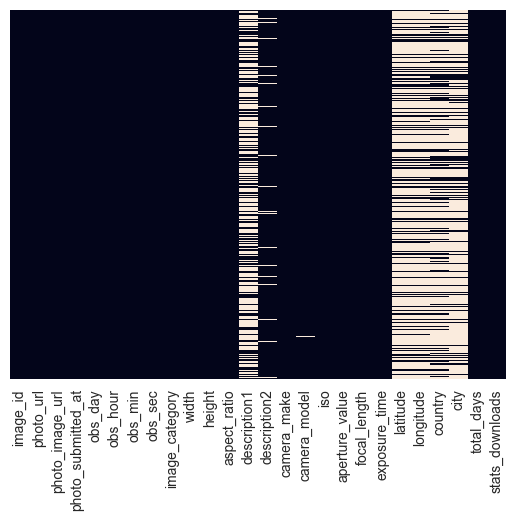

In [161]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False)

In [163]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12121 entries, 0 to 12196
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   image_id            12121 non-null  object        
 1   photo_url           12121 non-null  object        
 2   photo_image_url     12121 non-null  object        
 3   photo_submitted_at  12121 non-null  datetime64[ns]
 4   obs_day             12121 non-null  object        
 5   obs_hour            12121 non-null  int64         
 6   obs_min             12121 non-null  int64         
 7   obs_sec             12121 non-null  int64         
 8   image_category      12121 non-null  int64         
 9   width               12121 non-null  int64         
 10  height              12121 non-null  int64         
 11  aspect_ratio        12121 non-null  float64       
 12  description1        5102 non-null   object        
 13  description2        11471 non-null  object    

In [159]:
train["description2"].value_counts()

body of water                                                64
green-leafed plant                                           30
snow covered mountain during daytime                         26
white clouds                                                 21
snow covered mountain                                        21
                                                             ..
photo of snowy mountain                                       1
brown chipmunk on branch of tree                              1
aerial photography of concrete road near trees at daytime     1
Cinque Terre in Italy during daytime                          1
field of assorted-color-petaled flowers                       1
Name: description2, Length: 9828, dtype: int64

In [160]:
train[train["camera_model"].isnull()]

,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,description1,description2,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,latitude,longitude,country,city,total_days,stats_downloads
676,9a12bb8fe9,https://unsplash.com/photos/SQt0ZDqNapg,https://images.unsplash.com/photo-1552478099-e...,2019-03-13 11:55:56.485794,Wednesday,11,55,56,1,3992,2992,1.330,Wild Blues 🌊,bird's-eye photography of body of water,dji,NaN,200.000,2.200,4.790,0.013,NaN,NaN,NaN,NaN,1459,2977
2286,5aaa9a4bde,https://unsplash.com/photos/yhXzWu9ZMog,https://images.unsplash.com/photo-1555961182-4...,2019-04-22 19:26:32.656031,Monday,19,26,32,1,4096,2734,1.500,NaN,brown and green grass field during sunset,nan,NaN,50.000,2.800,20.000,0.001,NaN,NaN,NaN,NaN,1419,1372
2612,63c0ba214e,https://unsplash.com/photos/LPKk3wtkC-g,https://images.unsplash.com/photo-151120753875...,2017-11-20 19:52:50.441594,Monday,19,52,50,1,2412,4288,0.560,NaN,scenery of forest trees,nikon,NaN,160.000,3.500,50.000,0.004,NaN,NaN,NaN,NaN,1937,167386
2737,90bd79188c,https://unsplash.com/photos/XXX5HKsq4e0,https://images.unsplash.com/photo-1560804507-6...,2019-06-17 20:48:44.821429,Monday,20,48,44,1,4004,2669,1.500,NaN,brown antelope,canon,NaN,1000.000,5.600,400.000,0.005,NaN,NaN,Netherlands,NaN,1363,2911
3134,2618e3780c,https://unsplash.com/photos/YylrhMRSP_U,https://images.unsplash.com/photo-146085303913...,2016-04-17 00:31:35.410325,Sunday,0,31,35,1,4160,3120,1.330,NaN,two boat on body of water,nan,NaN,101.000,2.000,3.800,0.001,NaN,NaN,New Zealand,Christchurch,2519,8984
3333,aba93959bc,https://unsplash.com/photos/MhJJgPI7cNk,https://images.unsplash.com/photo-157966509279...,2020-01-22 03:52:09.552991,Wednesday,3,52,9,1,2731,4096,0.670,Pier with water splashing at sunset,brown wooden dock on sea during daytime,nan,NaN,200.000,2.500,35.000,0.002,34.953,-120.436,United States,Santa Maria,1144,887
3961,28e7a4e710,https://unsplash.com/photos/zb1-NiiWs5Q,https://images.unsplash.com/photo-158996704006...,2020-05-20 09:31:18.804735,Wednesday,9,31,18,1,4553,5691,0.800,Blue ambiance in the forest,green trees on foggy weather,nan,NaN,100.000,5.000,10.300,0.005,45.257,5.237,France,NaN,1025,4876
4018,454bb547b6,https://unsplash.com/photos/ZQwyFDqNxa0,https://images.unsplash.com/photo-145252005927...,2016-01-11 13:48:53.599048,Monday,13,48,53,1,5280,4227,1.250,A forest in the snow,withered trees surrounded by snow,nan,NaN,200.000,7.100,19.200,0.017,NaN,NaN,NaN,NaN,2616,20051
4028,8034cf0628,https://unsplash.com/photos/CQYSg3Hmwrs,https://images.unsplash.com/photo-1562517982-0...,2019-07-07 16:46:43.243258,Sunday,16,46,43,1,3240,2160,1.500,Football on Faroe islands #4,women's white shirt,nan,NaN,100.000,3.200,55.000,0.001,NaN,NaN,NaN,NaN,1343,2599
4145,629b45abeb,https://unsplash.com/photos/1E8qo-fplqo,https://images.unsplash.com/photo-158382752982...,2020-03-10 08:06:20.503797,Tuesday,8,6,20,1,5304,7952,0.670,Butterfly on Leaf,brown and black butterfly on white flower,nan,NaN,100.000,2.000,25.000,0.006,47.606,-122.332,United States,Seattle,1096,14598


In [68]:
# Categorical: obs_day, camera_make, camera_model
make_counts = train["camera_make"].value_counts()
make_counts
# make_counts[make_counts > 10].index

canon                    4855
nikon                    2639
sony                     2054
fujifilm                  854
dji                       452
apple                     318
panasonic                 264
olympus                   165
hasselblad                150
ricoh                     113
samsung                    51
nan                        40
gopro                      38
leica                      35
google                     30
pentax                     28
huawei                     22
xiaomi                     13
lge                         9
zwo                         6
oneplus                     6
motorola                    5
eastman kodak company       3
asus                        2
meizu                       2
leaf                        2
sigma                       2
zenit                       2
infocus                     1
phase one a/s               1
doogee                      1
htc                         1
mamiya                      1
lenovo    

In [122]:
train.describe()

,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,iso,aperture_value,focal_length,exposure_time,latitude,longitude,total_days,stats_downloads
count,12121.000,12121.000,12121.000,12121.000,12121.000,12121.000,12121.000,12069.000,12112.000,12121.000,12075.000,3444.000,3442.000,12121.000,12121.000
mean,12.667,29.316,29.793,0.992,4467.241,4245.747,1.140,554.550,4.919,67.228,3.538,34.798,-17.393,1572.249,9535.020
std,6.641,17.457,17.126,0.091,1330.902,1340.727,0.413,1368.444,3.747,89.538,93.626,25.333,79.901,529.571,22579.971
min,0.000,0.000,0.000,0.000,1275.000,774.000,0.340,0.000,0.950,0.000,0.000,-82.863,-159.639,897.000,152.000
25%,7.000,14.000,15.000,1.000,3538.000,3334.000,0.670,100.000,2.400,23.000,0.001,33.728,-87.906,1201.000,1502.000
50%,14.000,29.000,30.000,1.000,4092.000,4000.000,1.330,200.000,4.000,44.000,0.004,43.064,-0.166,1414.000,2769.000
75%,18.000,44.000,44.000,1.000,5472.000,5243.000,1.500,400.000,6.300,70.000,0.010,48.712,16.266,1588.000,7705.000
max,23.000,59.000,59.000,1.000,16384.000,14850.000,3.950,51200.000,40.000,1176.000,9415.000,78.227,177.202,3562.000,299344.000


In [129]:
train[train.exposure_time < 1000]

,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,description1,description2,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,latitude,longitude,country,city,total_days,stats_downloads
0,68105c019b,https://unsplash.com/photos/7AcMUSYRZpU,https://images.unsplash.com/photo-147455715737...,2016-09-22 15:13:10.134081,Thursday,15,13,10,1,2592,1728,1.500,Pristine water lily,rule of thirds photography of pink and white l...,canon,Canon EOS 60D,200.000,14.000,50.000,0.017,NaN,NaN,USA,"Wichita, Kansas",2361,167503
1,06d11c4edd,https://unsplash.com/photos/grWwLCSRr4o,https://images.unsplash.com/photo-157005349769...,2019-10-02 21:59:51.712464,Wednesday,21,59,51,1,4000,6000,0.670,NaN,sand in desert,sony,ILCE-6500,100.000,2.500,30.000,0.001,NaN,NaN,NaN,NaN,1255,1839
2,f6599edba1,https://unsplash.com/photos/OR4q9_Y2nuY,https://images.unsplash.com/photo-158018448188...,2020-01-28 04:10:11.128061,Tuesday,4,10,11,1,5504,8256,0.670,NaN,green trees near brown mountain during daytime,nikon,NIKON D850,64.000,2.800,48.000,0.001,NaN,NaN,NaN,NaN,1138,787
3,0f4bcc2d36,https://unsplash.com/photos/Qc3AmsZ3g2A,https://images.unsplash.com/photo-1542066365-0...,2018-11-12 23:46:21.990378,Monday,23,46,21,1,3627,2040,1.780,NaN,gray dock aerial photography,dji,FC220,139.000,2.200,4.700,0.010,32.785,-79.785,United States,Isle of Palms,1579,2049
4,74db502ed5,https://unsplash.com/photos/6BLE9HVwIJw,https://images.unsplash.com/photo-158781208024...,2020-04-25 11:04:20.912527,Saturday,11,4,20,1,4896,3264,1.500,NaN,people walking on green grass field near lake ...,fujifilm,X-T10,400.000,6.400,22.200,0.002,66.075,-23.125,Island,Ísafjörður,1050,2982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12192,18eaca644e,https://unsplash.com/photos/mcUVoqtEzF0,https://images.unsplash.com/photo-156924396944...,2019-09-23 13:07:25.355936,Monday,13,7,25,1,4480,6111,0.730,NaN,calm water during night time,canon,Canon EOS 5D Mark IV,100.000,5.600,300.000,0.003,NaN,NaN,NaN,NaN,1265,2353
12193,eb25cd769e,https://unsplash.com/photos/DDcD7ZrD4YU,https://images.unsplash.com/photo-1548707519-4...,2019-01-28 20:32:28.827831,Monday,20,32,28,1,2403,3337,0.720,NaN,snowflakes on ground,canon,Canon EOS 5D Mark III,400.000,5.000,100.000,0.003,NaN,NaN,NaN,NaN,1503,3541
12194,73302461d0,https://unsplash.com/photos/pI2BcDA6Hsw,https://images.unsplash.com/photo-146241318325...,2016-05-05 01:54:16.982329,Thursday,1,54,16,1,5184,3456,1.500,Inside of the small wave,NaN,canon,Canon EOS M,400.000,4.000,21.000,0.000,-37.818,174.839,New Zealand,Raglan,2501,14581
12195,f2587b2b08,https://unsplash.com/photos/nwFNYen-dHY,https://images.unsplash.com/photo-146186648824...,2016-04-28 18:02:32.922228,Thursday,18,2,32,1,6000,4000,1.500,Tropical palm,low angle of banana tree,nikon,NIKON D5300,800.000,1.800,50.000,0.003,40.727,13.903,Italy,NaN,2508,9247


<Axes: xlabel='stats_downloads', ylabel='Density'>

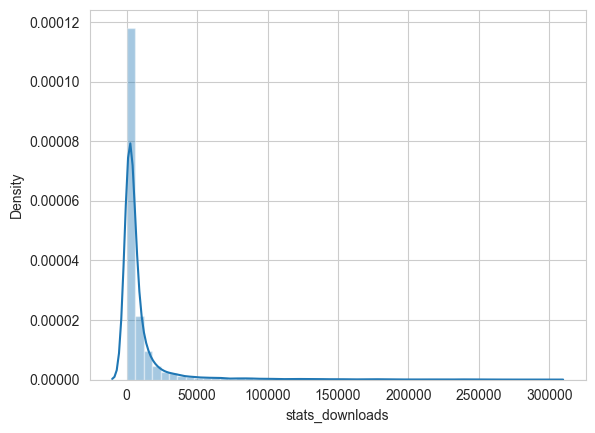

In [92]:
sns.distplot(train["stats_downloads"])

<Axes: xlabel='stats_downloads', ylabel='Density'>

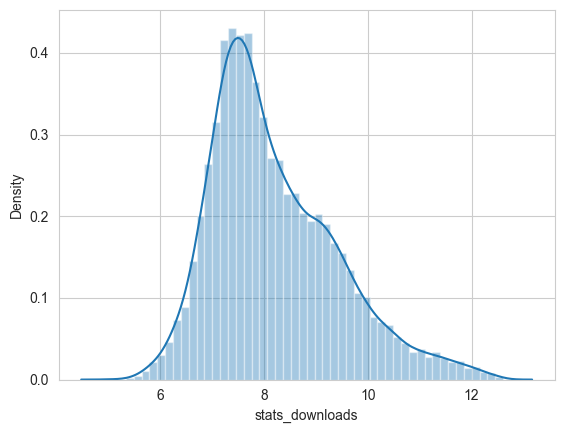

In [93]:
sns.distplot(np.log1p(train["stats_downloads"]))

In [94]:
corrs = []
for col in train_num.columns[:-1]:
    corr = train[col].corr(train["stats_downloads"])
    corrs.append(corr)
    # print(f"Column {col}: {corr}")

corr_df = pd.DataFrame({"col": train_num.columns[:-1], "corr": corrs})
corr_df.sort_values("corr", ascending=False)

# total_days is strongest predictor

,col,corr
12,total_days,0.370
6,aspect_ratio,0.119
8,aperture_value,0.063
3,image_category,0.029
10,latitude,0.015
7,iso,0.003
0,obs_hour,0.002
4,width,0.002
9,focal_length,-0.001
1,obs_min,-0.002


# Initial Findings/Ideas

## Findings
* "total_days" is most highly correlated with "stats_downloads"

## Ideas
* Day of the week, time of day effect on downloads
* If image_category = "Not Featured", very low downloads

<Axes: >

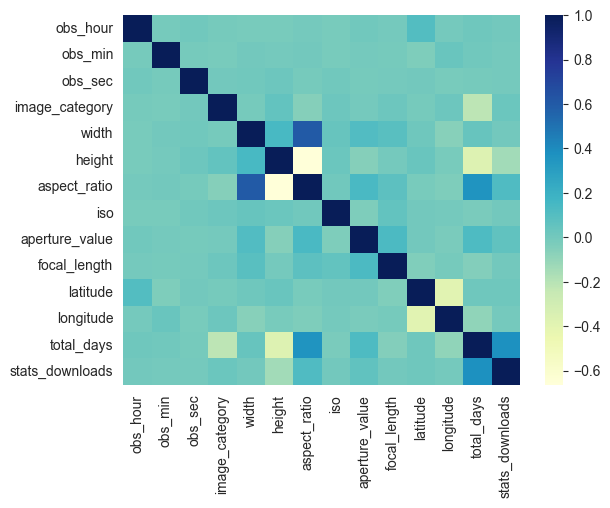

In [95]:
sns.heatmap(train_num.corr(), cmap="YlGnBu")

<Axes: >

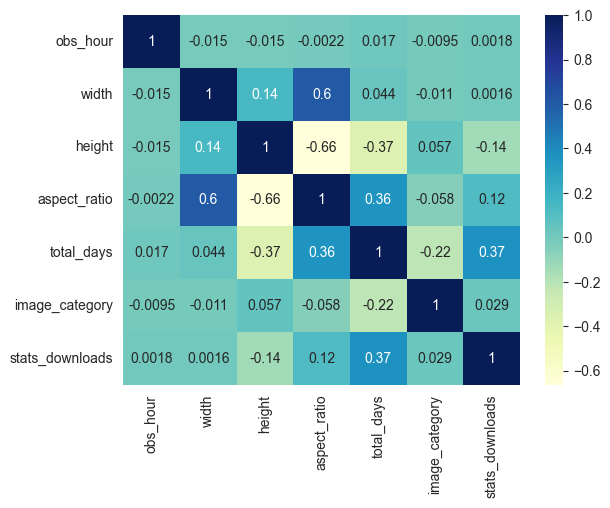

In [96]:
train_sub = train[["obs_hour", "width", "height", "aspect_ratio", "total_days", "image_category", "stats_downloads"]]
sns.heatmap(data=train_sub.corr(), cmap="YlGnBu", annot=True)

In [69]:
train_num.columns

Index(['obs_hour', 'obs_min', 'obs_sec', 'image_category', 'width', 'height',
       'aspect_ratio', 'iso', 'aperture_value', 'focal_length', 'latitude',
       'longitude', 'total_days', 'stats_downloads'],
      dtype='object')

In [ ]:
# Columns to drop
to_drop = ['obs_hour', 'obs_min', 'obs_sec', 'width', 'height', 'iso', 'aperture_value', 'focal_length', 'latitude',
       'longitude', 'total_days', 'stats_downloads']

In [83]:
train.dtypes

image_id               object
photo_url              object
photo_image_url        object
photo_submitted_at     object
obs_day                object
obs_hour                int64
obs_min                 int64
obs_sec                 int64
image_category          int64
width                   int64
height                  int64
aspect_ratio          float64
description1           object
description2           object
camera_make            object
camera_model           object
iso                   float64
aperture_value        float64
focal_length          float64
exposure_time          object
latitude              float64
longitude             float64
country                object
city                   object
total_days              int64
stats_downloads         int64
dtype: object

<Axes: xlabel='total_days', ylabel='stats_downloads'>

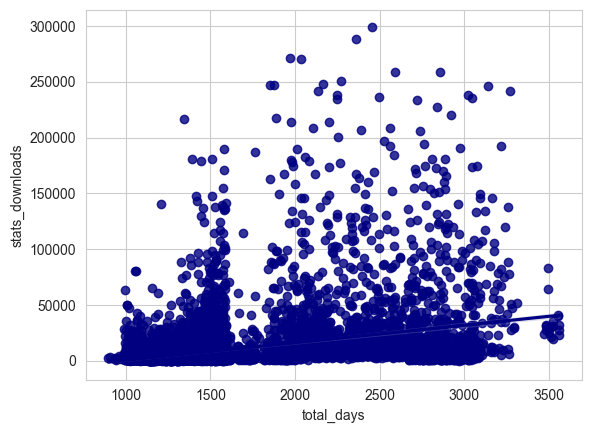

In [70]:
sns.regplot(x="total_days", y="stats_downloads", color="navy", data=train)

<Axes: xlabel='exposure_time', ylabel='stats_downloads'>

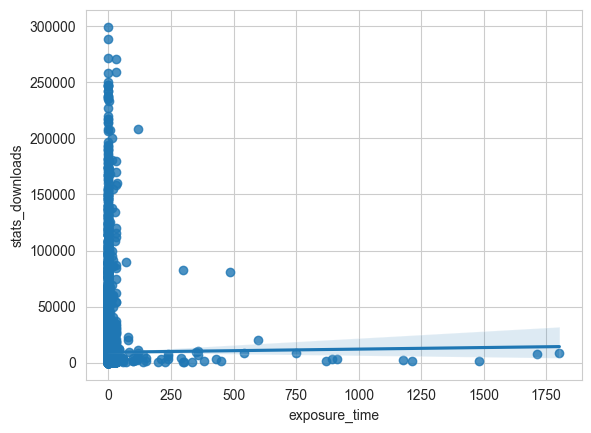

In [131]:
sns.regplot(x="exposure_time", y="stats_downloads", data=train[train.exposure_time < 2000])

<Axes: xlabel='aspect_ratio', ylabel='stats_downloads'>

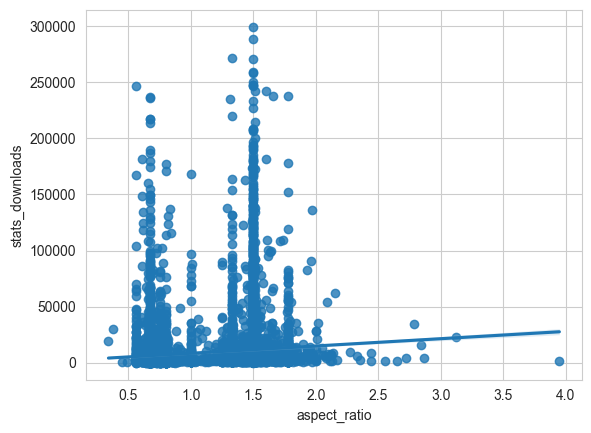

In [203]:
sns.regplot(x="aspect_ratio", y="stats_downloads", data=train)

<Axes: xlabel='total_days', ylabel='height'>

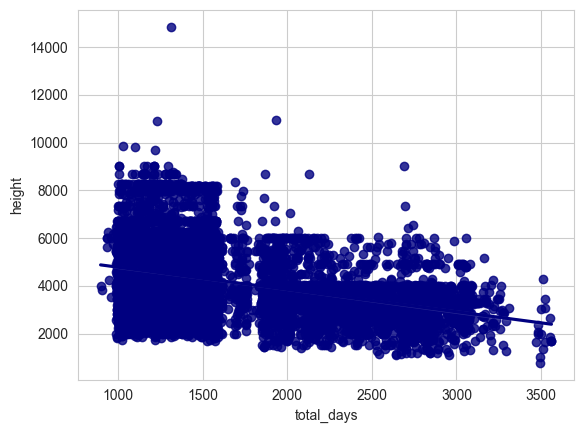

In [200]:
sns.regplot(x="total_days", y="height", color="navy", data=train)

<Axes: xlabel='total_days', ylabel='aspect_ratio'>

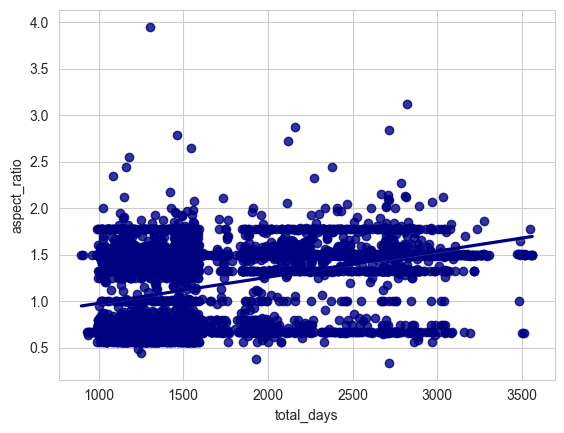

In [201]:
sns.regplot(x="total_days", y="aspect_ratio", color="navy", data=train)

<Axes: xlabel='height', ylabel='stats_downloads'>

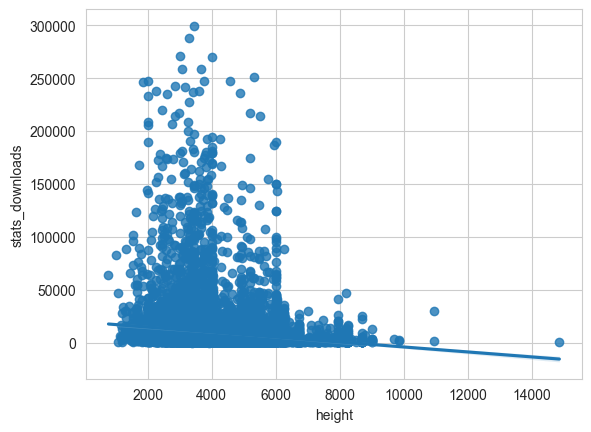

In [197]:
sns.regplot(x="height", y="stats_downloads", data=train)

In [222]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Initial XGBoost testing
data = train.select_dtypes(include=np.number)
X = data.drop(columns="stats_downloads")
y = data["stats_downloads"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=8)

In [237]:
X

,obs_hour,image_category,aspect_ratio,total_days
0,15,1,1.500,2361
1,21,1,0.670,1255
2,4,1,0.670,1138
3,23,1,1.780,1579
4,11,1,1.500,1050
...,...,...,...,...
12192,13,1,0.730,1265
12193,20,1,0.720,1503
12194,1,1,1.500,2501
12195,18,1,1.500,2508


In [227]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)
# xgb = XGBRegressor()
xgb = XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8255063664935096,
             colsample_bynode=0.9566459979367115,
             colsample_bytree=0.7745652753956729, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=9.034580483401264, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.02796171154881776, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=np.nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=8)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

21681.5142541869

In [206]:
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBRegressor

estimators = [
    ('encoder', TargetEncoder()),
    ('regr', XGBRegressor(random_state=8)) # can customize objective function with the objective parameter
]
pipe = Pipeline(steps=estimators)
pipe

Pipeline(steps=[('encoder', TargetEncoder()),
                ('regr',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=8, ...))])

In [217]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

search_space = {
    # 'regr__max_depth': Integer(2,8),
    'regr__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'regr__subsample': Real(0.5, 1.0),
    'regr__colsample_bytree': Real(0.5, 1.0),
    'regr__colsample_bylevel': Real(0.5, 1.0),
    'regr__colsample_bynode' : Real(0.5, 1.0),
    'regr__reg_alpha': Real(0.0, 10.0),
    'regr__reg_lambda': Real(0.0, 10.0),
    'regr__gamma': Real(0.0, 10.0)
}

opt = BayesSearchCV(pipe, search_space, cv=3, n_iter=10, scoring='neg_root_mean_squared_error', random_state=8) 
# in reality, you may consider setting cv and n_iter to higher values

In [218]:
opt.fit(X, y)

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('encoder', TargetEncoder()),
                                        ('regr',
                                         XGBRegressor(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=None,
                                                      grow_policy=None,
                                                      importance_type=N...
                             'regr__gamma': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'regr__learning_rate': Real(low=0.001, high=1.0, prior='log-uniform', transform='normalize'),
                             'regr__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'regr__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'regr__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [219]:
opt.best_estimator_

Pipeline(steps=[('encoder', TargetEncoder(cols=[])),
                ('regr',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=0.8255063664935096,
                              colsample_bynode=0.9566459979367115,
                              colsample_bytree=0.7745652753956729,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=9.034580483401264,
                              gpu_id=None, g...y=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.02796171154881776, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=None,
                              max_leaves=None, min_child_weight=None,
                              missing=nan, monotone_constraints=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, predictor=None,
                              random_state=8, ...))])

In [220]:
opt.best_score_

-20802.16068150209

In [221]:
opt.score(X, y)

-20402.938553502623